In [45]:
# Global imports

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px

import warnings

warnings.filterwarnings('ignore')

In [46]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [47]:
import os

root_folder = "/gdrive/MyDrive/corona_tweet_sentiment"
data_folder = os.path.join(root_folder, "data")

In [48]:
train_df = pd.read_csv(data_folder+'/train.csv', encoding = "ISO-8859-1")
test_df = pd.read_csv(data_folder+'/test.csv', encoding = "ISO-8859-1")

Let's concatenate train and test dataframes into one and deal with it.

In [80]:
df = pd.concat([train_df, test_df])

In [81]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Since for sentiment analysis we only need text and it's respective label, I'm gonna drop all the remaining columns(UserName, ScreenName, Location, TweetAt) from the above dataset

In [82]:
df = df.drop(["UserName", "ScreenName", "Location", "TweetAt"], axis=1)

In [52]:
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  44955 non-null  object
 1   Sentiment      44955 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


No Null Values

In [54]:
df.nunique()

OriginalTweet    44955
Sentiment            5
dtype: int64

No duplicates. Let's plot the distribution of the classes

In [55]:
df["Sentiment"].value_counts(normalize=True)

Positive              0.275142
Negative              0.243755
Neutral               0.185341
Extremely Positive    0.160672
Extremely Negative    0.135091
Name: Sentiment, dtype: float64

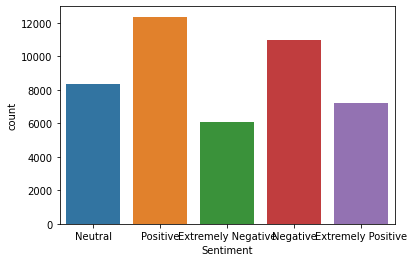

In [57]:
sns.countplot(df["Sentiment"])

Our aim is to classify the tweet into positive, negative and neutral as extremely negative/positive don't give as much information. 

So, I'm gonna assign **Extremely Positive/Negative = Positive/Negative**. Therefore, our task will become multi-class classification problem with just 3 classes viz.

**0: Neutral  
1: Positive  
2: Negative**         

In [83]:
df["Sentiment"] = df["Sentiment"].replace(["Extremely Positive", "Extremely Negative"],["Positive","Negative"])

In [59]:
df["Sentiment"].value_counts(normalize=True)

Positive    0.435814
Negative    0.378846
Neutral     0.185341
Name: Sentiment, dtype: float64

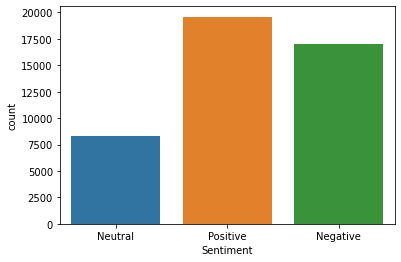

In [60]:
sns.countplot(df["Sentiment"])

**Class Imbalance Problem** : As we can see instances of Neutral class are very less as compared to other classes. We can't rely on accuracy as a metric for classification as model will be biased towards classes of more instances. We will address this issue later

#EDA

Let's visualize No. of characters in text

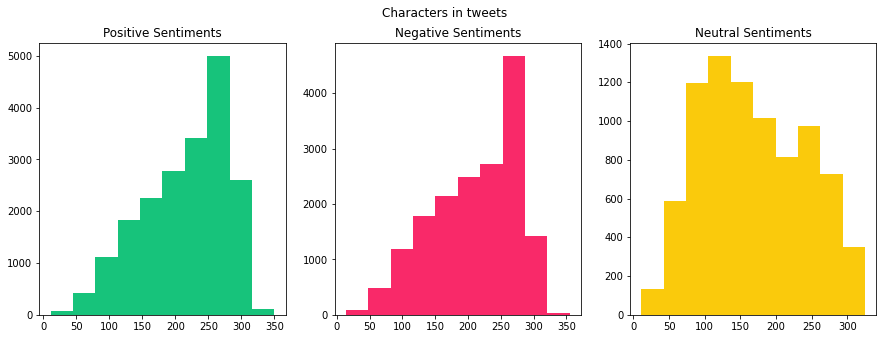

In [61]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=df[df['Sentiment']=="Positive"]['OriginalTweet'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=df[df['Sentiment']=="Negative"]['OriginalTweet'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=df[df['Sentiment']=="Neutral"]['OriginalTweet'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

In [62]:
# No of tweets/No of words per tweet

def get_num_words_per_tweet(sample_texts):
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

n  = get_num_words_per_tweet(df["OriginalTweet"])

print(len(df)/n)

1404.84375


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('stopwords')

from collections import defaultdict,Counter

In [64]:
stop=set(stopwords.words('english'))

In [65]:
# Most common stop words
def create_corpus(target):
    corpus=[]
    
    for x in df[df['Sentiment']==target]['OriginalTweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 15 artists>

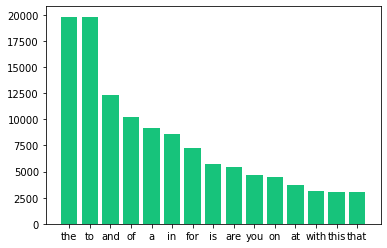

In [70]:
corpus=create_corpus("Positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 15 artists>

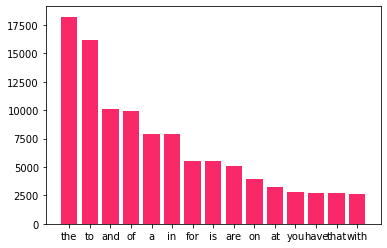

In [71]:
corpus=create_corpus("Negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')


**No Negation Problem**: We can see that most commmon stop words in both positive and negative tweets doesn't include "not" or "cannot". Negation words sometimes change the sentiment when they are included

Ex: 
"this is not good": Negative

"this is good": Positive

**Inference**: We can remove the stopwords from the corpus when cleaning as this is not a problem. 

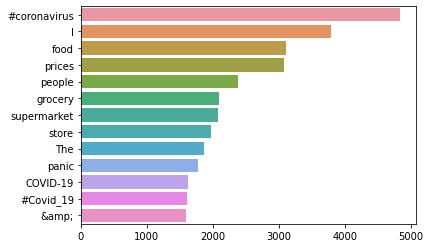

In [72]:
# Common Words
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

Common words include stop words. Need to pre-process

#Preprocessing

In [76]:
import re
import string

In [84]:
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['text']=df['OriginalTweet'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x:remove_html(x))

In [85]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
df['text']=df['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
df['text']=df['text'].apply(lambda x:remove_num(x))

In [86]:
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
df['text']=df['text'].apply(lambda x:punct_remove(x))



def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text']=df['text'].apply(lambda x:remove_stopwords(x))

In [88]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
df['text']=df['text'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
df['text']=df['text'].apply(lambda x:remove_hash(x))

In [89]:
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
df['text']=df['text'].apply(lambda x:remove_space(x))

In [90]:
df.head()

,OriginalTweet,Sentiment,text
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie phil_gahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,Positive,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",Negative,ready go supermarket covid outbreak im paranoi...


In [91]:
final_df = df.drop(["OriginalTweet"], axis=1)

In [95]:
final_df.head()

,Sentiment,text
0,Neutral,menyrbie phil_gahan chrisitv
1,Positive,advice talk neighbours family exchange phone n...
2,Positive,coronavirus australia woolworths give elderly ...
3,Positive,food stock one empty please dont panic enough ...
4,Negative,ready go supermarket covid outbreak im paranoi...


In [99]:
final_df.to_csv("/gdrive/MyDrive/corona_tweet_sentiment/data/final.csv", index=False)